<a href="https://colab.research.google.com/github/ReynaraEzra/Richter-Earthquake-Prediction/blob/main/Richter_Prediction_Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predict Earthquake Damage to Building in Nepal (Part 3)**
## **Reynara Ezra Pratama**

## **Importing Library**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

from sklearn.model_selection import RandomizedSearchCV
from xgboost import plot_importance

## **Loading Dataset**

In [ ]:
url_train_label = 'https://raw.githubusercontent.com/ReynaraEzra/Richter-Earthquake-Prediction/main/train_labels.csv'
url_train_value = 'https://raw.githubusercontent.com/ReynaraEzra/Richter-Earthquake-Prediction/main/train_values.csv'
url_test_value = 'https://raw.githubusercontent.com/ReynaraEzra/Richter-Earthquake-Prediction/main/test_values.csv'

train_label = pd.read_csv(url_train_label)
train_value = pd.read_csv(url_train_value)
test_value = pd.read_csv(url_test_value)

## **Data**

In [ ]:
train = pd.merge(train_value, train_label)

In [ ]:
train.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


## **Feature Selection**

In [ ]:
corr_matrix = train.corr()
corr_matrix

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
building_id,1.000000,-0.002850,0.000347,-0.000393,-0.000654,-0.001476,-0.002070,0.000096,-0.000307,0.002423,0.001443,-0.000827,-0.003768,0.001933,0.001967,0.001266,0.002472,-0.002259,0.002171,-0.000599,0.002606,0.002631,0.001934,-0.002152,0.000706,-0.000362,0.002348,-0.000374,0.000538,-0.003116,-0.002295,0.001063
geo_level_1_id,-0.002850,1.000000,-0.061405,0.002718,-0.089364,-0.003908,0.071158,-0.063474,-0.018245,-0.152038,0.007677,0.023656,-0.028854,0.134121,0.144985,0.074169,0.016454,0.015767,0.022670,0.035108,-0.010428,-0.019786,0.001911,0.023523,0.003700,0.002977,0.002655,-0.002303,0.001060,0.000523,-0.017992,-0.072347
geo_level_2_id,0.000347,-0.061405,1.000000,0.000921,0.047730,0.012594,-0.049443,0.035516,0.015833,0.076491,-0.008743,-0.009122,0.014246,-0.079875,-0.023927,-0.032588,-0.038173,-0.036074,-0.020144,-0.012439,-0.001519,0.017522,-0.008439,-0.030704,-0.004840,-0.004856,0.000687,-0.000757,-0.000152,0.001926,-0.013068,0.043161
geo_level_3_id,-0.000393,0.002718,0.000921,1.000000,-0.021646,-0.006385,-0.005643,-0.024507,-0.015732,0.026294,0.019579,0.005966,-0.023278,-0.005116,-0.003916,0.006143,0.002265,-0.012420,-0.010604,-0.002479,0.007375,0.015995,-0.002001,-0.007356,-0.007058,-0.004373,-0.000862,-0.002632,-0.000943,0.000269,-0.002463,0.007932
count_floors_pre_eq,-0.000654,-0.089364,0.047730,-0.021646,1.000000,0.086668,0.101071,0.772734,0.174852,-0.027116,-0.041058,-0.011329,0.257279,-0.085821,-0.056637,-0.070487,0.007448,0.049000,-0.029888,0.086586,0.052125,-0.005294,0.077120,0.035425,0.016384,0.008833,-0.002611,0.006786,0.009639,0.003939,-0.002073,0.122308
age,-0.001476,-0.003908,0.012594,-0.006385,0.086668,1.000000,-0.004323,0.061074,0.068032,0.001321,0.009129,-0.012128,0.079525,-0.036992,0.005855,-0.008374,-0.025431,-0.025552,-0.001520,0.005309,-0.008788,-0.002194,-0.010021,0.001193,-0.004189,-0.003514,-0.003658,-0.002169,-0.001764,-0.001195,-0.004534,0.029273
area_percentage,-0.002070,0.071158,-0.049443,-0.005643,0.101071,-0.004323,1.000000,0.196645,0.026287,-0.225541,-0.000473,0.073701,0.053362,0.210800,-0.053965,-0.031641,0.185047,0.224647,0.007928,0.088630,0.122401,-0.016478,0.159885,0.105983,0.052212,0.050164,0.019421,0.015109,0.015290,0.004983,0.013111,-0.125221
height_percentage,0.000096,-0.063474,0.035516,-0.024507,0.772734,0.061074,0.196645,1.000000,0.149725,-0.106573,-0.020260,0.012960,0.209098,0.001698,-0.052402,-0.063342,0.086228,0.129698,-0.019266,0.064316,0.091780,-0.005390,0.123551,0.068909,0.031366,0.020032,0.001946,0.011192,0.014660,0.004048,0.005397,0.048130
has_superstructure_adobe_mud,-0.000307,-0.018245,0.015833,-0.015732,0.174852,0.068032,0.026287,0.149725,1.000000,-0.306861,0.006962,-0.014554,0.314979,-0.037549,0.011694,0.011528,-0.036830,-0.036782,0.057545,0.033068,-0.013300,-0.003917,-0.012642,-0.003935,-0.004281,-0.002369,0.001762,-0.003292,-0.002648,-0.001493,-0.010074,0.055314
has_superstructure_mud_mortar_stone,0.002423,-0.152038,0.076491,0.026294,-0.027116,0.001321,-0.225541,-0.106573,-0.306861,1.000000,-0.034046,-0.104288,-0.376208,-0.470715,-0.040177,-0.054657,-0.222366,-0.224509,-0.041705,0.001576,-0.087520,0.058261,-0.159532,-0.117948,-0.036064,-0.023070,-0.025507,-0.008763,-0.011904,-0.003380,0.005628

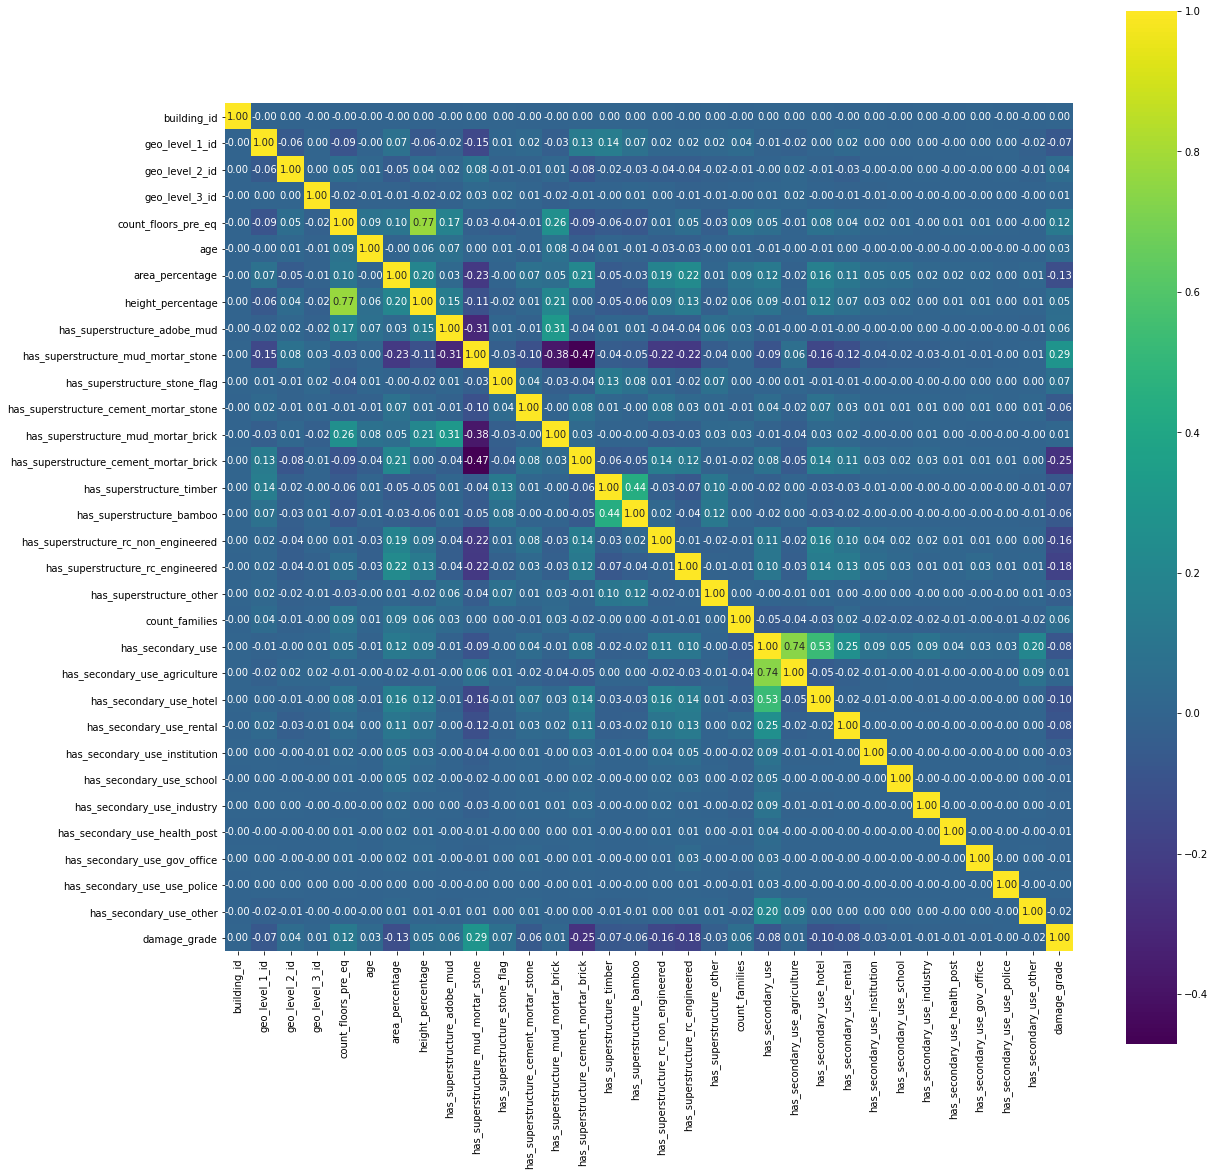

In [ ]:
plt.figure(figsize=(19,19))

sns.heatmap(corr_matrix, annot=True, cmap='viridis', square=True, fmt='.2f', annot_kws={'size': 10})
plt.show()

Pada gambar di atas, terlihat terdapat feature yang mempunyai korelasi yang tinggi dengan feature lainnya. Feature ***height_percentage*** dan ***has_secondary_use_agriculture*** memiliki tingkat korelasi yang tinggi (> 0,7) dengan feature lain.

In [ ]:
target_corr_matrix = corr_matrix['damage_grade'].drop('damage_grade').sort_values(ascending=False)
target_corr_matrix

has_superstructure_mud_mortar_stone       0.291325
count_floors_pre_eq                       0.122308
has_superstructure_stone_flag             0.066039
count_families                            0.056151
has_superstructure_adobe_mud              0.055314
height_percentage                         0.048130
geo_level_2_id                            0.043161
age                                       0.029273
has_superstructure_mud_mortar_brick       0.014561
has_secondary_use_agriculture             0.011309
geo_level_3_id                            0.007932
building_id                               0.001063
has_secondary_use_use_police             -0.001656
has_secondary_use_health_post            -0.008543
has_secondary_use_gov_office             -0.009378
has_secondary_use_industry               -0.011024
has_secondary_use_school                 -0.011692
has_secondary_use_other                  -0.016334
has_secondary_use_institution            -0.028728
has_superstructure_other       

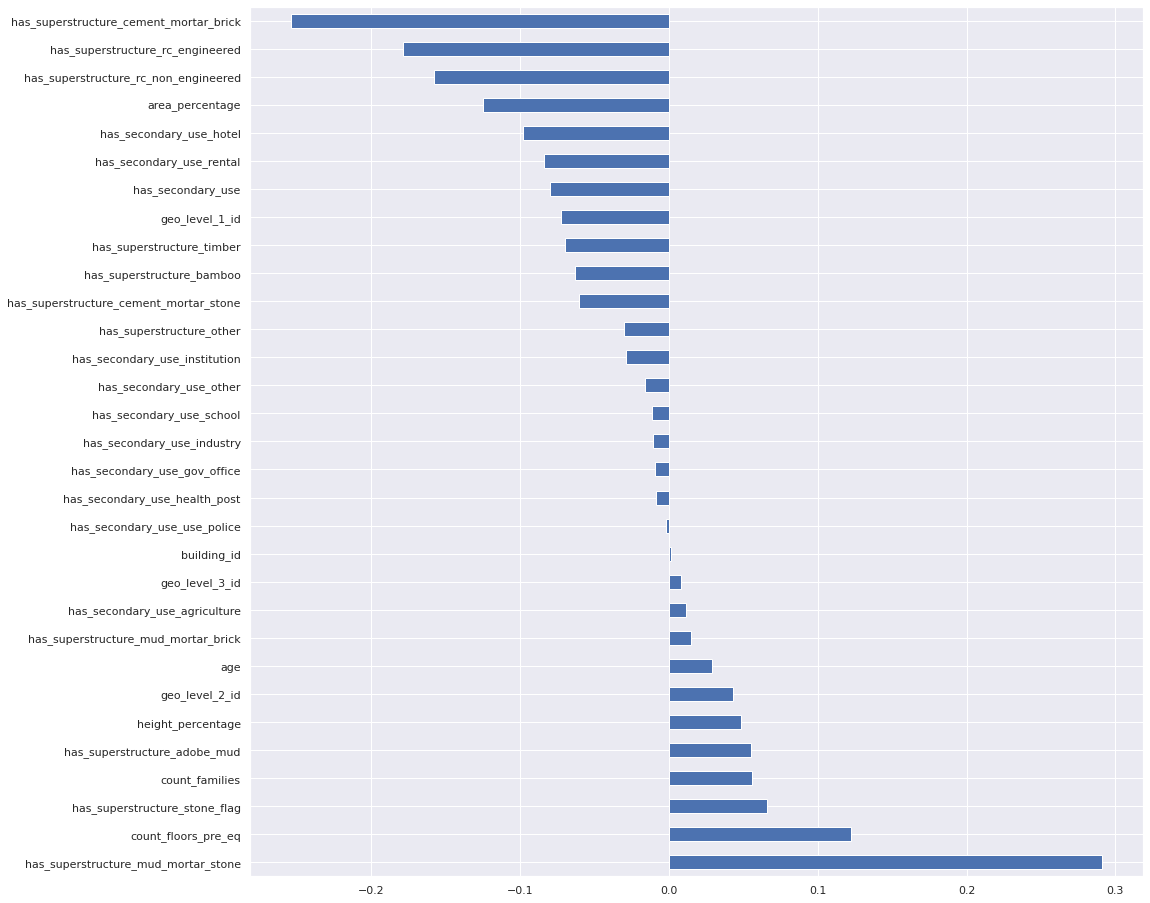

In [ ]:
plt.figure(figsize=(16,16))
sns.set_theme()
target_corr_matrix.plot(kind='barh')
plt.show()

In [ ]:
df = train.copy()
df = df.set_index('building_id')

**Pisahkan Feature Numerik dan Kategorikal**

In [ ]:
df_num = df.select_dtypes(include=['int64', 'float64'])
df_cat = df.select_dtypes(include=['object'])

**Feature Selection Untuk Feature Numerik**

Pada matrik korelasi sebelumnya terlihat bahwa terdapat dua buah feature yang memiliki tingkat korelasi yang tinggi (>0.7). Penggunakan matrik korelasi dapat dilakukan untuk mengecek multicollinearity. Multicollinearity dapat menimbulkan masalah seperti redudansi dimana dua feature tersebut dapat menyimpan informasi yang serupa/mirip. Dalam mengatasi multicollinearity, kita dapat membuang dua buah feature tersebut atau salah satu agar tidak ada feature yang mempunyai tingkat korelasi yang tinggi dengan feature lain. Akan dicek antara feature ***height_percentage*** dan ***has_secondary_use_agriculture*** yang mempunyai tingkat korelasi lebih tinggi terhadap target ***damage_grade***.

In [ ]:
print('Korelasi feature height_percentange dengan damage_grade : {:.4f}'.format(target_corr_matrix['height_percentage']))
print('Korelasi feature has_secondary_use_agriculture dengan damage_grade : {:.4f}'.format(target_corr_matrix['has_secondary_use_agriculture']))

Korelasi feature height_percentange dengan damage_grade : 0.0481
Korelasi feature has_secondary_use_agriculture dengan damage_grade : 0.0113


Berdasarkan nilai korelasi di atas, terlihat bahwa feature ***height_percentage*** mempunyai tingkat korelasi yang lebih tinggi, maka kita akan membuang feature ***has_secondary_use_agriculture***.

In [ ]:
df_num.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3
28830,8,900,2812,2,10,8,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2
94947,21,363,8973,2,10,5,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3
590882,22,418,10694,2,10,6,5,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2
201944,11,131,1488,3,30,8,9,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3


In [ ]:
df_num = df_num.drop('has_secondary_use_agriculture', axis=1)

In [ ]:
df_num.shape

(260601, 30)

**Feature Selection Untuk Feature Kategorikal**

Proses pemilihan feature yang bertipe kategorikal akan menggunakan *SelectKBest*. Menggunakan hal ini, digunakan metrics *chi squared* yang mana jika *chi squared* semakin tinggi, maka semakin signifikan pengaruh dari feature tersebut.

In [ ]:
df_cat.head()

,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status
building_id,,,,,,,,
802906,t,r,n,f,q,t,d,v
28830,o,r,n,x,q,s,d,v
94947,t,r,n,f,x,t,d,v
590882,t,r,n,f,x,s,d,v
201944,t,r,n,f,x,s,d,v


In [ ]:
df_cat = pd.get_dummies(df_cat)

In [ ]:
df_cat.head()

,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
28830,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
94947,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
590882,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
201944,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
df_cat.shape

(260601, 38)

In [ ]:
category_rank_feature = SelectKBest(score_func=chi2, k=38)
rank_feature = category_rank_feature.fit(df_cat, df_num['damage_grade'])
rank_feature.scores_

array([3.14202700e+02, 6.77046429e+01, 6.77640172e+01, 4.15860728e+02,
       2.79293047e+04, 6.39195232e+03, 5.49424844e+03, 8.31579458e+03,
       1.04584801e+03, 1.15697625e+03, 2.80485950e+04, 3.68489235e+03,
       9.75543604e+01, 3.24654211e+04, 6.05516649e+01, 1.22429528e+02,
       7.42291993e+03, 5.10846128e+03, 1.85494082e+04, 4.06602490e+02,
       2.59354872e+02, 1.48779877e+02, 4.93714399e+01, 6.22421247e+02,
       1.09200110e+02, 1.50572497e+02, 3.04753264e+01, 3.34305427e+00,
       1.36435198e+01, 1.65187836e+00, 5.72019260e+01, 3.23110604e+02,
       3.31565900e+01, 1.01176162e+03, 2.26362245e+03, 5.34417037e+01,
       3.96056239e+01, 2.29493063e+02])

In [ ]:
cat_score = pd.DataFrame(rank_feature.scores_, columns=['Score'])
cat_col = pd.DataFrame(df_cat.columns, columns=['Feature'])
univariate_cat_rank = pd.concat([cat_col, cat_score], axis=1)
univariate_cat_rank.set_index('Feature', inplace=True)
sorted_univariate_cat_rank = univariate_cat_rank.sort_values('Score', ascending=False)
#sorted_univariate_cat_rank

In [ ]:
chi2_greater100 = sorted_univariate_cat_rank[sorted_univariate_cat_rank['Score']>100]

**Merge Feature Numerik dan Kategorikal**

In [ ]:
df_new = pd.concat([df_num, df_cat], axis=1)

In [ ]:
df_new.sample(6)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
435874,8,558,3025,2,70,3,4,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
296208,25,58,5093,2,5,9,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
661151,7,225,3129,2,70,8,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
276490,10,1224,7745,2,45,5,6,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
183654,21,477,8993,3,5,10,7,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
135671,8,268,4727,2,25,11,6,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


## **Scaling Feature**

In [ ]:
standar_scaler = StandardScaler()
scaled_df = df_new.copy()

scaled_col = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 
              'count_floors_pre_eq', 'age', 'area_percentage', 
              'height_percentage']

feature_scaled = scaled_df[scaled_col]
feature_scaled = standar_scaler.fit_transform(feature_scaled)
scaled_df[scaled_col] = feature_scaled
data = scaled_df.copy()

In [ ]:
data.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,-0.983414,-0.518705,1.629055,-0.178274,0.047100,-0.459460,-0.226419,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
28830,-0.734459,0.481998,-0.945017,-0.178274,-0.224765,-0.004110,0.816109,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
94947,0.883744,-0.819158,0.744612,-0.178274,-0.224765,-0.687135,-0.226419,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
590882,1.008221,-0.685893,1.216589,-0.178274,-0.224765,-0.459460,-0.226419,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
201944,-0.361028,-1.381296,-1.308119,1.195989,0.047100,-0.004110,1.858636,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
data.tail()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
688636,1.381653,1.536007,-1.271644,-1.552536,0.386932,-0.459460,-1.268946,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
669485,0.385835,0.033741,-1.151250,-0.178274,-0.360698,-0.459460,-0.226419,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
602512,0.385835,-1.575137,0.522472,1.195989,0.386932,-0.459460,0.816109,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
151409,1.506130,-1.604213,-1.208568,-0.178274,-0.224765,1.361941,0.294845,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
747594,0.883744,-1.676903,0.779715,1.195989,-0.224765,-0.231785,0.294845,0,1,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
data.sample(5)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
267229,-1.107891,-1.272261,0.274280,-0.178274,-0.156799,0.906591,-0.747683,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,2,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
234384,1.506130,0.726722,1.645509,-0.178274,-0.360698,-0.687135,-0.747683,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
636054,0.385835,0.554688,0.747628,1.195989,-0.088832,-0.231785,0.816109,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
602399,0.385835,0.421423,0.540024,1.195989,-0.360698,-0.459460,0.294845,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
478885,-1.356845,1.662003,-0.022728,3.944513,-0.156799,-0.914810,3.943691,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


## **Building Model**

In [ ]:
y = data['damage_grade']
X = data[list(df_num.columns)+list(chi2_greater100.index)]
X.drop('damage_grade', axis=1, inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((208480, 54), (52121, 54), (208480,), (52121,))

## **Hyperparameter Tuning**

Pada bagian sebelumnya, diperoleh 2 buah algoritma yang menghasilkan nilai F1 Score tertinggi yaitu Extreme *Gradient Boosting* dan *Random Forest*. Oleh karena itu, kita akan melakukan proses *Hyperparameter Tuning* pada dua algoritma tersebut. Proses *hyperparameter tuning* dapat melakukan GridSearchCV atau RandomizedCV. Pada permasalahan kali ini, kita akan menggunakan RandomizedCV.

**RandomizedCV**

**Extreme Gradient Boosting Parameter Tuning**

In [ ]:
xgb_params = {'n_estimators':range(50, 201, 50),
              'max_depth': range(3, 15)}
xgb_model = XGBClassifier()
kfold = KFold(n_splits=4)
rscv_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=xgb_params, n_iter=5,
                              cv=kfold, random_state=0, n_jobs=-1)

rscv_xgb.fit(X,y)
print("Optimal hyperparameter combination for XGBClassifier:", rscv_xgb.best_params_)
print()
print("Mean cross-validated training accuracy score:", rscv_xgb.best_score_)

Optimal hyperparameter combination for XGBClassifier: {'n_estimators': 150, 'max_depth': 10}

Mean cross-validated training accuracy score: 0.7354883539158392


**Random Forest Parameter Tuning**

In [ ]:
params = {'n_estimators': range(50, 301, 50),
          'max_depth': range(3, 30),
          'max_features': ['sqrt', 'log2', None]}

rf_model = RandomForestClassifier()
kfold = KFold(n_splits=4)
rscv_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=params, n_iter=20, 
                             scoring='f1_micro', cv=kfold, random_state=0, n_jobs=-1)

rscv_rf.fit(X,y)
print("Optimal hyperparameter combination for RandomForestClassifier:", rscv_rf.best_params_)
print()
print("Mean cross-validated training accuracy score:", rscv_rf.best_score_)

Optimal hyperparameter combination for RandomForestClassifier: {'n_estimators': 50, 'max_features': None, 'max_depth': 22}

Mean cross-validated training accuracy score: 0.7311253580780692


## **Build Model with Parameter Tuning**

**Extreme Gradient Boosting**

In [ ]:
tuning_xgb_model = XGBClassifier(n_estimators=150, max_depth=10)
tuning_xgb_model.fit(X_train,y_train)
pred_xgb = tuning_xgb_model.predict(X_test)
train_pred_xgb = tuning_xgb_model.predict(X_train)
print('F1 Score (Micro) on Training Data :', f1_score(y_train, train_pred_xgb, average='micro'))
print('F1 Score (Micro) on Testing Data :', f1_score(y_test, pred_xgb, average='micro'))

F1 Score (Micro) on Training Data : 0.791159823484267
F1 Score (Micro) on Testing Data : 0.7369006734329734


**Random Forest**

In [ ]:
tuning_rf_model = RandomForestClassifier(n_estimators=50, max_features=None, max_depth=22)
tuning_rf_model.fit(X_train,y_train)
pred_rf = tuning_rf_model.predict(X_test)
train_pred_rf = tuning_rf_model.predict(X_train)
print('F1 Score (Micro) on Training Data :', f1_score(y_train, train_pred_rf, average='micro'))
print('F1 Score (Micro) on Testing Data :', f1_score(y_test, pred_rf, average='micro'))

F1 Score (Micro) on Training Data : 0.913396968534152
F1 Score (Micro) on Testing Data : 0.7345024078586366


## **Feature Importance of Both Model**

**Extreme Gradient Boosting**

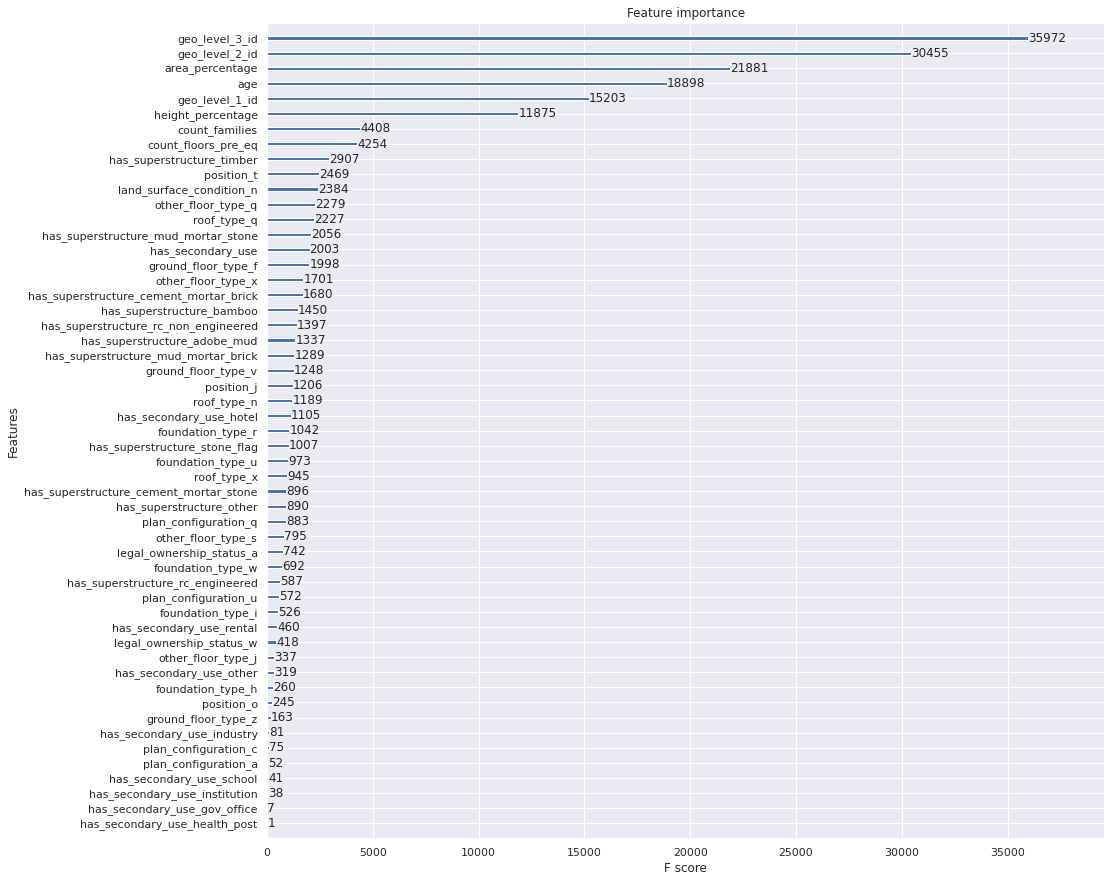

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
plot_importance(tuning_xgb_model, max_num_features=55, ax=ax)
plt.show()

**Random Forest**

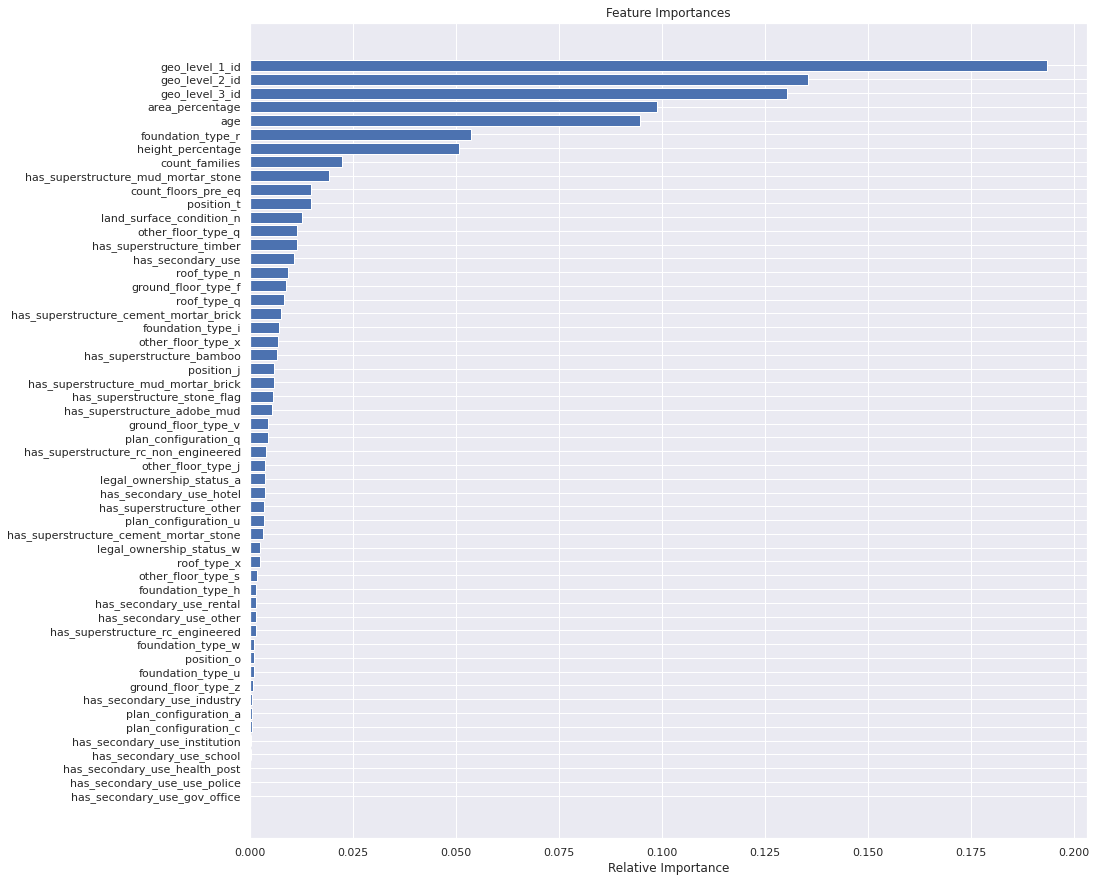

In [ ]:
features = X.columns
importances = tuning_rf_model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(15,15))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

## **Final Model**

Setelah dilakukan proses parameter tuning untuk *Extreme Gradient Boosting* dan *Random Forest*, diperoleh nilai F1 score untuk kedua model pada *training data* dan *validation data*. Terlihat untuk model pada *Extreme Gradient Boosting* lebih stabil karena nilai F1 score pada *training data* dan *validation data* berada di rentang 79% dan 73%. Sementara pada model *Random Forest*, nilai F1 score pada *training data* adalah 91% dan 73% pada *validation data*. Sehingga pada model akhir, kita akan menggunakan *Extreme Gradient Boosting* untuk memprediksi *test data*.

In [ ]:
final_model = XGBClassifier(n_estimators=150, max_depth=10)
final_model.fit(X, y)
pred_final_model = final_model.predict(X)
cm_final_model = confusion_matrix(y, pred_final_model)
print('F1 Score (Micro) on Training Data :', f1_score(y, pred_final_model, average='micro'))
print('Confusion matrix: \n',cm_final_model)
print('Classification report: \n',classification_report(y, pred_final_model))

F1 Score (Micro) on Training Data : 0.7865319012590128
Confusion matrix: 
 [[ 15032   9832    260]
 [  2785 132106  13368]
 [   295  29090  57833]]
Classification report: 
               precision    recall  f1-score   support

           1       0.83      0.60      0.70     25124
           2       0.77      0.89      0.83    148259
           3       0.81      0.66      0.73     87218

    accuracy                           0.79    260601
   macro avg       0.80      0.72      0.75    260601
weighted avg       0.79      0.79      0.78    260601



## **Predict Unseen Data**

In [ ]:
X.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,ground_floor_type_v,roof_type_x,foundation_type_i,other_floor_type_s,foundation_type_w,other_floor_type_j,foundation_type_r,foundation_type_u,other_floor_type_q,ground_floor_type_f,legal_ownership_status_a,roof_type_q,roof_type_n,plan_configuration_u,position_t,foundation_type_h,other_floor_type_x,plan_configuration_q,land_surface_condition_n,position_j,legal_ownership_status_w,plan_configuration_c,position_o,ground_floor_type_z,plan_configuration_a
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,-0.983414,-0.518705,1.629055,-0.178274,0.047100,-0.459460,-0.226419,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
28830,-0.734459,0.481998,-0.945017,-0.178274,-0.224765,-0.004110,0.816109,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
94947,0.883744,-0.819158,0.744612,-0.178274,-0.224765,-0.687135,-0.226419,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0
590882,1.008221,-0.685893,1.216589,-0.178274,-0.224765,-0.459460,-0.226419,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
201944,-0.361028,-1.381296,-1.308119,1.195989,0.047100,-0.004110,1.858636,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
test_data = test_value.copy()
test_data = test_data.set_index('building_id')
test_data.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0
890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0
421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_data_num = test_data.select_dtypes(include=['int64', 'float64'])
test_data_cat = test_data.select_dtypes(include=['object'])

In [ ]:
test_data_num = test_data_num.drop('has_secondary_use_agriculture', axis=1)

In [ ]:
test_data_cat = pd.get_dummies(test_data_cat)

In [ ]:
new_test_data = pd.concat([test_data_num, test_data_cat], axis=1)

In [ ]:
scaler = StandardScaler()
scaled_test = new_test_data.copy()
data_train = df_new.copy()
scaled_col = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 
              'count_floors_pre_eq', 'age', 'area_percentage', 
              'height_percentage']

scaled_train = data_train[scaled_col]
scaler.fit(scaled_train)
feature_scaled_test = scaled_test[scaled_col]
feature_scaled_test = scaler.transform(feature_scaled_test)
scaled_test[scaled_col] = feature_scaled_test
data_test = scaled_test.copy()

In [ ]:
data_test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
300051,0.385835,-0.254597,1.384702,1.195989,-0.088832,-0.231785,0.294845,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
99355,-0.983414,-1.357066,1.571189,-0.178274,-0.020866,1.134266,-0.226419,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
890251,1.008221,-1.652673,1.038329,-0.178274,-0.292732,-0.914810,-0.226419,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
745817,1.506130,-1.604213,-1.542599,-1.552536,-0.360698,2.500317,-1.268946,0,0,0,0,0,1,0,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
421793,0.385835,-0.998461,0.469543,1.195989,-0.156799,-0.004110,0.816109,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
testing = data_test[list(df_num.drop('damage_grade', axis=1).columns)+list(chi2_greater100.index)]

In [ ]:
pred_testing_data = final_model.predict(testing)

In [ ]:
final = pd.DataFrame()
final['building_id'] = testing.index
final['damage_grade'] = pred_testing_data

In [ ]:
final

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,2
3,745817,1
4,421793,3
...,...,...
86863,310028,2
86864,663567,3
86865,1049160,2
86866,442785,2


In [ ]:
final.to_csv('Damage Grade Prediction.csv', index=False)

## **Conclusion**

Berdasarkan proses yang telah dilakukan, dapat diperoleh beberapa kesimpulan yang dapat menajwab permasalahan sebelumnya. Kesimpulan ini diharapkan dapat menjawab permasalahan yang telah didefinisikan sebelumnya.

1. Mendapatkan gambaran bagaimana kerusakan yang ada pada bangunan yang ada di Nepal <br>
Jawab :  <br>
Setelah melakukan proses *Exploratory Data Analysis*, diperoleh rata-rata tingkat kerusakan yang ada sebesar **2,238272** yang menyatakan bangunan mengalami tingkat kerusakan menengah. Adapun lengkapnya adalah sebanyak **148259** bangunan mengalami tingkat kerusakan menengah, **87218** bangunan mengalami tingkat kerusakan tinggi, dan **25124** bangunan mengalami tingkat kerusakan rendah. Terlihat bahwa jumlah bangunan dengan tingkat kerusakan mengengah adalah yang paling banyak yaitu sebesar **56.89%** diikuti oleh bangunan dengan tingkat kerusakan tinggi sebesar **33.47%** dan terakhir bangunan dengan tingkat kerusakan rendah sebesar **9.64%**. Tingkatan level geografis yang semakin tinggi antara ***geo_level_1_id***, ***geo_level_2_id***, dan ***geo_level_3_id*** memberikan informasi bahwa semakin tinggi level geografis, tingkat kerusakan semakin sama.

2. Memberikan rekomendasi berupa material atau karakteristik spesifik yang dapat digunakan dalam membangun suatu bangunan untuk mengurangi dampak kerusakan yang ditimbulkan dari gempa bumi.  <br>
Jawab :  <br>
Diperoleh bangunan yang mengalami tingkat kerusakan terbanyak adalah bangunan dengan kriteria material dan karakteristik sebagai berikut.
    *   Bangunan yang menggunakan superstruktur ***Reinforce Concrete Engineered*** atau ***Cement Mortar Brick***
    *   Bangunan dengan jumlah lantai sebanyak **1** atau **3**
    *   Bangunan dengan tinggi ternormalisasi kurang dari **3** meter atau lebih dari **9** meter
    *   Bangunan dengan luas ternormalisasi kurang dari **4** meter persegi atau lebih dari **10** meter persegi.

3.  Memprediksi level kerusakan bangunan yang terkena dampak gempa bumi Nepal 2015.  <br>
Jawab :  <br>
Proses prediksi tingkat kerusakan yang disebabkan oleh gempa Nepal 2015 terhadap bangunan dapat kita prediksi menggunakan algoritma *Machine Learning*. Model dengan nilai *F1 Score* tertinggi dalam memprediksi tingkat kerusakan akibat gempa bumi terhadap bangunan adalah model algoritma ***Extreme Gradient Boosting*** menggunakan *XGBClassifier* dengan memasukkan parameter `n_estimators=150` dan `max_depth=10`. Menggunakan model ini diperoleh nilai *F1 Score* sebesar **73,69%**. Menggunakan model ini, dapat dilihat beberapa faktor penting dalam memprediksi tingkat kerusakan adalah *geo_level_3_id*, *geo_level_2_id*, *area_percentage*, *age*, dan *height_percentage*.
